## Assignment 7:
#### ENAS :




In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import SeparableConv2D, Concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.core import Lambda

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Load cifar using the load data function
# The data is in the shape of (Batch_size, num_channel, width, height)
# np.unique returns unique class names

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(num_classes)

170500096/170498071 [==============================] - 6s 0us/step
number of training examples = 50000, image rows = 32, image columns = 32 and image channels = 3
number of test examples = 10000
total number of unique classes are 10 = 


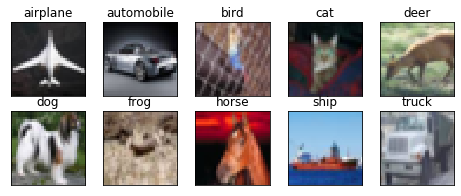

In [3]:
# Visualization of some particular classes from the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5,1 + i, xticks=[], yticks=[])
    # gets the all the position of a particular class
    idx = np.where(train_labels[:]==i)[0]
    # using the idx we can find the corresponding image arrays
    features_idx = train_features[idx,::]
    # selects an img num by random
    img_num = np.random.randint(features_idx.shape[0])
    # gets the img array by img num
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Normalize data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# Convert class labels to binary class labels
train_labels = tfk.utils.to_categorical(train_labels, num_classes)
test_labels = tfk.utils.to_categorical(test_labels, num_classes)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def skip_connection_step(input_value, scale, channels_for_addition=None):
  """ function to change the dimensions of the input to be merged with layer where it will be merged for skip connection
    # Arguments
      input: Input tensor
      scale: n `int` that is `>= 2`. The size of the spatial block.
      channels_for_addition: number of channels for the addition of parameters for merging
    # Returns
      layer output for the merge operation
  """
  out = tf.space_to_depth(input_value, block_size=scale)
  if(channels_for_addition):
    out = Convolution2D(channels_for_addition, 1, 1, kernel_regularizer=l2(0.0005))(out)
    out = BatchNormalization()(tower_6)
    out = Activation('relu')(out)
    out = Dropout(0.25)(out)
    
  return out


def space_to_depth_2(input):
  return tf.space_to_depth(input, 2)

def space_to_depth_4(input):
  return tf.space_to_depth(input, 4)

In [8]:
input_img = Input(shape=(32, 32, 3))

################### first tower  ###################

# block 1
block_1_input = input_img
sep_5_5_1 = SeparableConv2D(16, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005), input_shape=(32, 32, 3))(block_1_input)
sep_5_5_1 = BatchNormalization()(sep_5_5_1)
sep_5_5_1 = Activation('relu')(sep_5_5_1)
sep_5_5_1 = Dropout(0.25)(sep_5_5_1)

sep_5_5_1_skip_scale_2 = Lambda(space_to_depth_2)(sep_5_5_1)
sep_5_5_1_skip_scale_4 = Lambda(space_to_depth_4)(sep_5_5_1)

# block 2
block_2_input = sep_5_5_1
conv_5_5_1 = Convolution2D(16, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_2_input)
conv_5_5_1 = BatchNormalization()(conv_5_5_1)
conv_5_5_1 = Activation('relu')(conv_5_5_1)
conv_5_5_1 = Dropout(0.2)(conv_5_5_1)

conv_5_5_1_skip_scale_2 = Lambda(space_to_depth_2)(conv_5_5_1)
conv_5_5_1_skip_scale_4 = Lambda(space_to_depth_4)(conv_5_5_1)

# block 3
block_3_input = conv_5_5_1
conv_5_5_2 = Convolution2D(16, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_3_input)
conv_5_5_2 = BatchNormalization()(conv_5_5_2)
conv_5_5_2 = Activation('relu')(conv_5_5_2)
conv_5_5_2 = Dropout(0.2)(conv_5_5_2)

conv_5_5_2_skip_scale_2 = Lambda(space_to_depth_2)(conv_5_5_2)
conv_5_5_2_skip_scale_4 = Lambda(space_to_depth_4)(conv_5_5_2)

# block 4
block_4_input = Concatenate()([conv_5_5_2, sep_5_5_1])
sep_5_5_2 = SeparableConv2D(16, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_4_input)
sep_5_5_2 = BatchNormalization()(sep_5_5_2)
sep_5_5_2 = Activation('relu')(sep_5_5_2)
sep_5_5_2 = Dropout(0.25)(sep_5_5_2)

sep_5_5_2_skip_scale_2 = Lambda(space_to_depth_2)(sep_5_5_2)
sep_5_5_2_skip_scale_4 = Lambda(space_to_depth_4)(sep_5_5_2)

# maxpool 1
maxpool_1_input = Concatenate()([sep_5_5_2, sep_5_5_1])
maxpool_1_output = MaxPooling2D(pool_size=(2, 2))(maxpool_1_input)



################### Second tower  ###################

# block 5
block_5_input = maxpool_1_output
sep_3_3_1 = SeparableConv2D(32, 3, 3, border_mode='same', kernel_regularizer=l2(0.0005))(block_5_input)
sep_3_3_1 = BatchNormalization()(sep_3_3_1)
sep_3_3_1 = Activation('relu')(sep_3_3_1)
sep_3_3_1 = Dropout(0.25)(sep_3_3_1)

sep_3_3_1_skip_scale_2 = Lambda(space_to_depth_2)(sep_3_3_1)
sep_3_3_1_skip_scale_4 = Lambda(space_to_depth_4)(sep_3_3_1)

# block 6
block_6_input = Concatenate()([conv_5_5_2_skip_scale_2, sep_3_3_1])
conv_5_5_3 = Convolution2D(32, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_6_input)
conv_5_5_3 = BatchNormalization()(conv_5_5_3)
conv_5_5_3 = Activation('relu')(conv_5_5_3)
conv_5_5_3 = Dropout(0.2)(conv_5_5_3)

conv_5_5_3_skip_scale_2 = Lambda(space_to_depth_2)(conv_5_5_3)
conv_5_5_3_skip_scale_4 = Lambda(space_to_depth_4)(conv_5_5_3)

# block 7
block_7_input = Concatenate()([sep_5_5_2_skip_scale_2, sep_3_3_1, conv_5_5_3, conv_5_5_2_skip_scale_2])
sep_3_3_2 = SeparableConv2D(32, 3, 3, border_mode='same', kernel_regularizer=l2(0.0005))(block_7_input)
sep_3_3_2 = BatchNormalization()(sep_3_3_2)
sep_3_3_2 = Activation('relu')(sep_3_3_2)
sep_3_3_2 = Dropout(0.25)(sep_3_3_2)

sep_3_3_2_skip_scale_2 = Lambda(space_to_depth_2)(sep_3_3_2)
sep_3_3_2_skip_scale_4 = Lambda(space_to_depth_4)(sep_3_3_2)

# block 8
block_8_input = Concatenate()([sep_5_5_2_skip_scale_2, sep_3_3_1, sep_3_3_2, conv_5_5_3, conv_5_5_2_skip_scale_2])
sep_5_5_3 = SeparableConv2D(32, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_8_input)
sep_5_5_3 = BatchNormalization()(sep_5_5_3)
sep_5_5_3 = Activation('relu')(sep_5_5_3)
sep_5_5_3 = Dropout(0.25)(sep_5_5_3)

sep_5_5_3_skip_scale_2 = Lambda(space_to_depth_2)(sep_5_5_3)
sep_5_5_3_skip_scale_4 = Lambda(space_to_depth_4)(sep_5_5_3)

# maxpool 2
maxpool_2_input = Concatenate()([sep_5_5_2_skip_scale_2, sep_3_3_1, sep_5_5_3, sep_3_3_2])
maxpool_2_output = MaxPooling2D(pool_size=(2, 2))(maxpool_2_input)


################### Third tower  ###################

# block 9
block_9_input = Concatenate()([conv_5_5_3_skip_scale_2, maxpool_2_output])
conv_5_5_4 = Convolution2D(64, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_9_input)
conv_5_5_4 = BatchNormalization()(conv_5_5_4)
conv_5_5_4 = Activation('relu')(conv_5_5_4)
conv_5_5_4 = Dropout(0.2)(conv_5_5_4)

# block 10
block_10_input = Concatenate()([sep_5_5_2_skip_scale_4, conv_5_5_4, sep_3_3_2_skip_scale_2, sep_5_5_1_skip_scale_4])
sep_5_5_4 = SeparableConv2D(64, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_10_input)
sep_5_5_4 = BatchNormalization()(sep_5_5_4)
sep_5_5_4 = Activation('relu')(sep_5_5_4)
sep_5_5_4 = Dropout(0.25)(sep_5_5_4)

# block 11
block_11_input = Concatenate()([sep_3_3_1_skip_scale_2, sep_5_5_4, conv_5_5_4, conv_5_5_2_skip_scale_4, conv_5_5_1_skip_scale_4])
conv_3_3_1 = Convolution2D(64, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_11_input)
conv_3_3_1 = BatchNormalization()(conv_3_3_1)
conv_3_3_1 = Activation('relu')(conv_3_3_1)
conv_3_3_1 = Dropout(0.2)(conv_3_3_1)

# block 12
block_12_input = Concatenate()([sep_5_5_2_skip_scale_4, sep_3_3_1_skip_scale_2, sep_5_5_1_skip_scale_4, sep_5_5_4, conv_3_3_1, conv_5_5_2_skip_scale_4, sep_3_3_2_skip_scale_2])
sep_5_5_5 = SeparableConv2D(64, 5, 5, border_mode='same', kernel_regularizer=l2(0.0005))(block_12_input)
sep_5_5_5 = BatchNormalization()(sep_5_5_5)
sep_5_5_5 = Activation('relu')(sep_5_5_5)
sep_5_5_5 = Dropout(0.25)(sep_5_5_5)


output = Concatenate()([sep_5_5_2_skip_scale_4, sep_5_5_4, sep_5_5_5, sep_3_3_2_skip_scale_2])

output = Convolution2D(32, 1, 1, kernel_regularizer=l2(0.0005))(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.25)(output)




output = Convolution2D(10, 8, 8, kernel_regularizer=l2(0.0005))(output)
output = Activation('relu')(output)

output = Flatten()(output)
output = Activation('softmax')(output)



model = Model(inputs=[input_img], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(16, (5, 5), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  import sys







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(16, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), kern



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 16)   139         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8), kernel_regularizer=<keras.reg...)`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
390/390 [==============================] - 78s 199ms/step - loss: 2.2587 - acc: 0.2070 - val_loss: 2.2129 - val_acc: 0.2148
Epoch 2/100
390/390 [==============================] - 68s 173ms/step - loss: 2.0948 - acc: 0.2708 - val_loss: 2.0158 - val_acc: 0.3208
Epoch 3/100
390/390 [==============================] - 68s 174ms/step - loss: 1.9463 - acc: 0.3414 - val_loss: 1.9081 - val_acc: 0.3537
Epoch 4/100
390/390 [==============================] - 68s 174ms/step - loss: 1.8360 - acc: 0.3790 - val_loss: 1.8128 - val_acc: 0.3785
Epoch 5/100
390/390 [==============================] - 68s 174ms/step - loss: 1.7461 - acc: 0.4116 - val_loss: 1.7563 - val_acc: 0.4047
Epoch 6/100
390/390 [==============================] - 68s 174ms/step - loss: 1.6493 - acc: 0.4481 - val_loss: 1.6260 - val_acc: 0.4735
Epoch 7/100
390/390 [==============================] - 68s 174ms/step - loss: 1.4778 - a

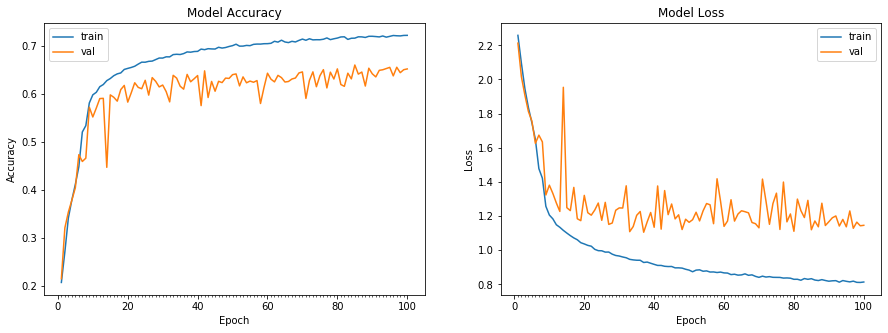

Accuracy on test data is: 65.23


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))